In [1]:
%env OMP_NUM_THREADS=1
import firedrake as fd
import numpy as np
import matplotlib.pyplot as plt
from scattering import *
from mesh import *

env: OMP_NUM_THREADS=1


In [2]:
def dirichlet_bc(k, d):
    def f(x):
        return -np.exp(1j * x.dot(d))
    return f

# Sphere

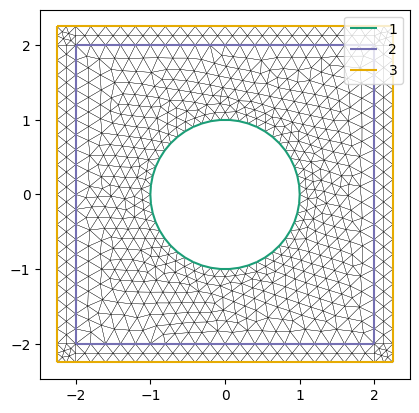

In [3]:
mesh = fd.Mesh("sphere0.msh")
plot_mesh(mesh)

In [4]:
c = 340
k = 1
omega = k * c
a0 = b0 = 2.0
a1 = b1 = 2.25
d = np.array([1., 0.])
d /= np.linalg.norm(d)

g_fct = dirichlet_bc(k, d)

In [5]:
uh = solve(mesh, k, a1, b1, g_fct)

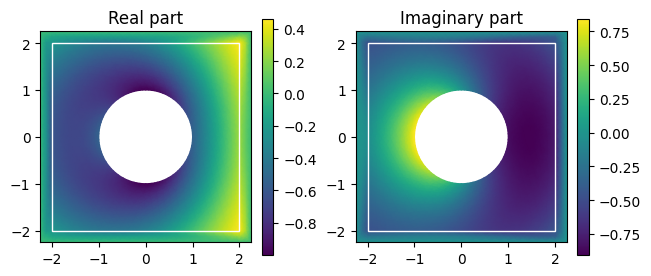

In [6]:
plot_field(uh, a0, a1, b0, b1)

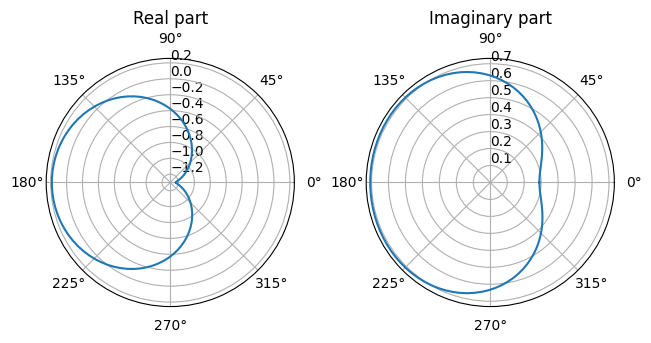

In [7]:
X = fd.SpatialCoordinate(mesh)
xd = fd.dot(fd.as_vector(d), X)
inc = (fd.cos(k * xd), fd.cos(k * xd))
plot_far_field(k, uh, inc)

# Kite

In [8]:
c = 340
d = np.array([1., 0.])
d /= np.linalg.norm(d)
h0 = 0.2

a0 = b0 = 3.0
a1 = b1 = 3.25
# mesh = generate_mesh(a0, a1, b0, b1, "kite")
mesh = fd.Mesh("kite0.msh")

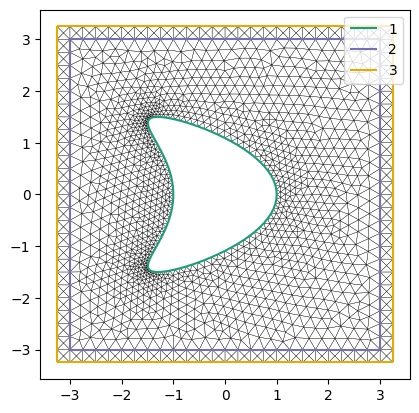

In [9]:
plot_mesh(mesh)

In [10]:
k = 1
omega = k * c

g_fct = dirichlet_bc(k, d)

In [11]:
uh = solve(mesh, k, a1, b1, g_fct)

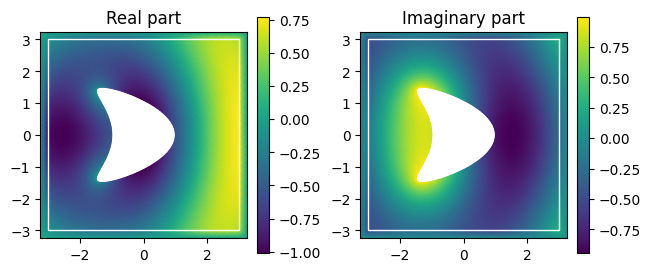

In [12]:
plot_field(uh, a0, a1, b0, b1)

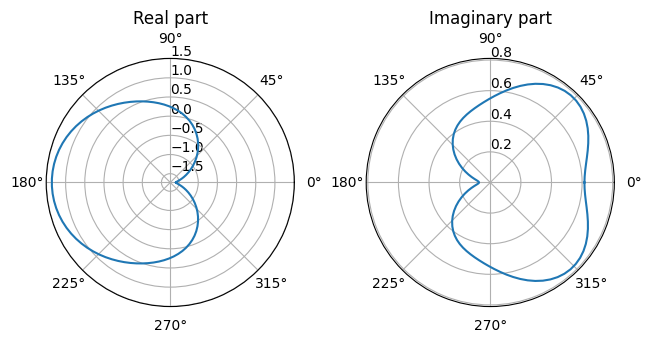

In [13]:
X = fd.SpatialCoordinate(mesh)
xd = fd.dot(fd.as_vector(d), X)
inc = (fd.cos(k * xd), fd.cos(k * xd))
plot_far_field(k, uh, inc)

In [14]:
u_inf_re, u_inf_im = far_field(k, uh, 0, inc)
print("Re{u_inf(d)} =", u_inf_re)
print("Im{u_inf(d)} =", u_inf_im)

Re{u_inf(d)} = -1.5822385613541514
Im{u_inf(d)} = 0.6152839049227037


In [15]:
u_inf_re, u_inf_im = far_field(k, uh, np.pi, inc)
print("Re{u_inf(-d)} =", u_inf_re)
print("Im{u_inf(-d)} =", u_inf_im)

Re{u_inf(-d)} = 1.360273445496225
Im{u_inf(-d)} = 0.07310285455206768


- $Re\{u_\infty(d)\} = −1.62745750, Im\{u_\infty(d)\} = 0.60222591$  
    $Re\{u_\infty(-d)\} = 1.39694488, Im\{u_\infty(-d)\} = 0.09499635$  
    (Colton and Kress - 2019, Table 3.1)

In [16]:
# Convergence
max_level = 5
levels = np.arange(max_level)
hs = h0 / 2**levels
u_inf_ref = np.array([-1.62745750, 0.60222591, 1.39694488, 0.09499635])

In [17]:
mesh_hierarchy = []
for level in levels:
    # mesh_hierarchy.append(generate_mesh(a0, a1, b0, b1, "kite", level))
    mesh_hierarchy.append(fd.Mesh("kite" + str(level) + ".msh"))

k = 1
refinement level 0, relative error [0.02778502 0.02168288 0.02625117 0.2304667 ]
refinement level 1, relative error [0.02496545 0.0179341  0.01664775 0.22891252]
refinement level 2, relative error [0.00816572 0.00044965 0.00645921 0.0073474 ]
refinement level 3, relative error [0.00387645 0.00137503 0.00630191 0.01778872]
refinement level 4, relative error [0.00207691 0.00108241 0.00325983 0.01191798]
----------------------------------------


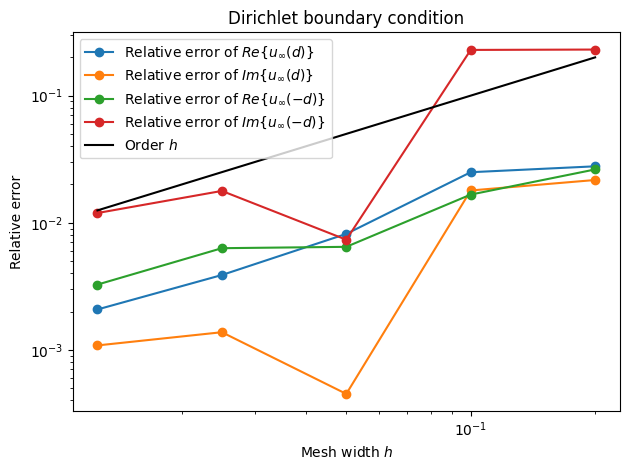

In [18]:
# Dirichlet problem
neumann = False
k = 1
print(f"k = {k}")
g_fct = dirichlet_bc(k, d)
errors = []
for level in levels:
    m = mesh_hierarchy[level]
    uh = solve(m, k, a1, b1, g_fct, neumann)

    X = fd.SpatialCoordinate(m)
    xd = fd.dot(fd.as_vector(d), X)
    inc = (fd.cos(k * xd), fd.cos(k * xd))
    u_inf = np.empty(4)
    u_inf[0], u_inf[1] = far_field(k, uh, 0, inc)
    u_inf[2], u_inf[3] = far_field(k, uh, np.pi, inc)
    rel_err = np.abs((u_inf - u_inf_ref) / u_inf_ref)
    print(f"refinement level {level}, relative error {rel_err}")
    errors.append(rel_err)
errors = np.array(errors)
plt.loglog(hs, errors[:, 0], "-o",
           label=r"Relative error of $Re\{u_\infty(d)\}$")
plt.loglog(hs, errors[:, 1], "-o",
           label=r"Relative error of $Im\{u_\infty(d)\}$")
plt.loglog(hs, errors[:, 2], "-o",
           label=r"Relative error of $Re\{u_\infty(-d)\}$")
plt.loglog(hs, errors[:, 3], "-o",
           label=r"Relative error of $Im\{u_\infty(-d)\}$")
print("----------------------------------------")

plt.loglog(hs, hs, "k", label=r"Order $h$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()